# Icon Recommendation System

### Introduction & Problem Statement

This project aims to develop an icon recommendation system to assist designers in finding icons with similar visual appearance and semantic meaning. The existing systems focus primarily on icon naming and not visual similarity, which may not always align well with the context or semantic similarity desired by designers. To address this, we are building a system that combines visual features extracted from icon images with textual features derived from icon names.

Our dataset contains 2259 icons from three popular icon sets: Feather Icons, Font Awesome, and Heroicons.

### Data Collection & Preprocessing

In [1]:
# imports
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from scipy.spatial.distance import cosine
from PIL import Image
from gensim.models import KeyedVectors
import gensim.downloader as api
import cairosvg

### EDA

In this section, we collect and preprocess the icon data. First, we standardize the icons from different sets by converting them to a consistent format, including resizing them to same size. This includes converting files to same format and resizing all icons to 128x128 pixels. This preprocessing step helps in reducing variability, making it easier for the deep learning model to process them uniformly. The preprocessing involves converting SVG files to PNG, resizing images, and handling transparency issues to create a unified dataset for feature extraction. The process will walk through all subdirectories (feather, font-awesome, heroicons). We also rename each icon to exclude the subfolder prefix.

In [2]:
# file sources
base_icon_folder = "original_icons"
target_folder = "standardized_icons"

# make new target folder if needed
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# function to convert to png and resize
def convert_and_resize(source_path, target_path):
    if source_path.endswith('.svg'):
        png_path = target_path.replace('.svg', '.png')
        cairosvg.svg2png(url=source_path, write_to=png_path)
        source_path = png_path
    if source_path.endswith('.png'):
        with Image.open(source_path) as img:
            img = img.resize((128, 128))
            img.save(target_path)

# check all subfolders and remove prefix
for subdir in os.listdir(base_icon_folder):
    subdir_path = os.path.join(base_icon_folder, subdir)
    if os.path.isdir(subdir_path):
        for root, _, files in os.walk(subdir_path):
            for filename in files:
                if filename.endswith('.svg') or filename.endswith('.png'):
                    source_path = os.path.join(root, filename)
                    if filename.startswith("feather_"):
                        target_filename = filename[len("feather_"):]
                    elif filename.startswith("font-awesome_"):
                        target_filename = filename[len("font-awesome_"):] 
                    elif filename.startswith("heroicons_"):
                        target_filename = filename[len("heroicons_"):] 
                    else:
                        target_filename = filename
                    target_path = os.path.join(target_folder, target_filename.replace('.svg', '.png'))
                    convert_and_resize(source_path, target_path)

# track process
total_images = len(os.listdir(target_folder))
print(f"Icons successfully standardized and saved in directory: {target_folder}. Total images: {total_images}")

Icons successfully standardized and saved in directory: standardized_icons. Total images: 2259


#### Loading Icon Images and Labels

Next, we load the preprocessed icons and prepare them for feature extraction. This involves converting the images to an appropriate format for visualization and feature extraction using a pre-trained MobileNet model.

In this step, we load the standardized icons from the target directory and prepare them for further processing.

In [3]:
# get icon images and labels
original_images = []
preprocessed_images = []
icon_labels = []

# process each image
for filename in os.listdir(target_folder):
    if filename.endswith('.png'):
        img_path = os.path.join(target_folder, filename)
        img = Image.open(img_path).convert('RGBA')
        background = Image.new('RGBA', img.size, (255, 255, 255, 255))
        img = Image.alpha_composite(background, img).convert('RGB')
        img = img.resize((128, 128))
        img_array = np.array(img)
        original_images.append(img_array)
        preprocessed_img_array = img_array.astype(np.float32)
        preprocessed_img_array = preprocess_input(preprocessed_img_array)
        preprocessed_images.append(preprocessed_img_array)
        icon_labels.append(filename.split('.')[0])

# lists to arrays
original_images = np.array(original_images)
preprocessed_images = np.array(preprocessed_images)

#### Visual Exploration: Random Samples of Icons

Random Samples of Icons from the Dataset



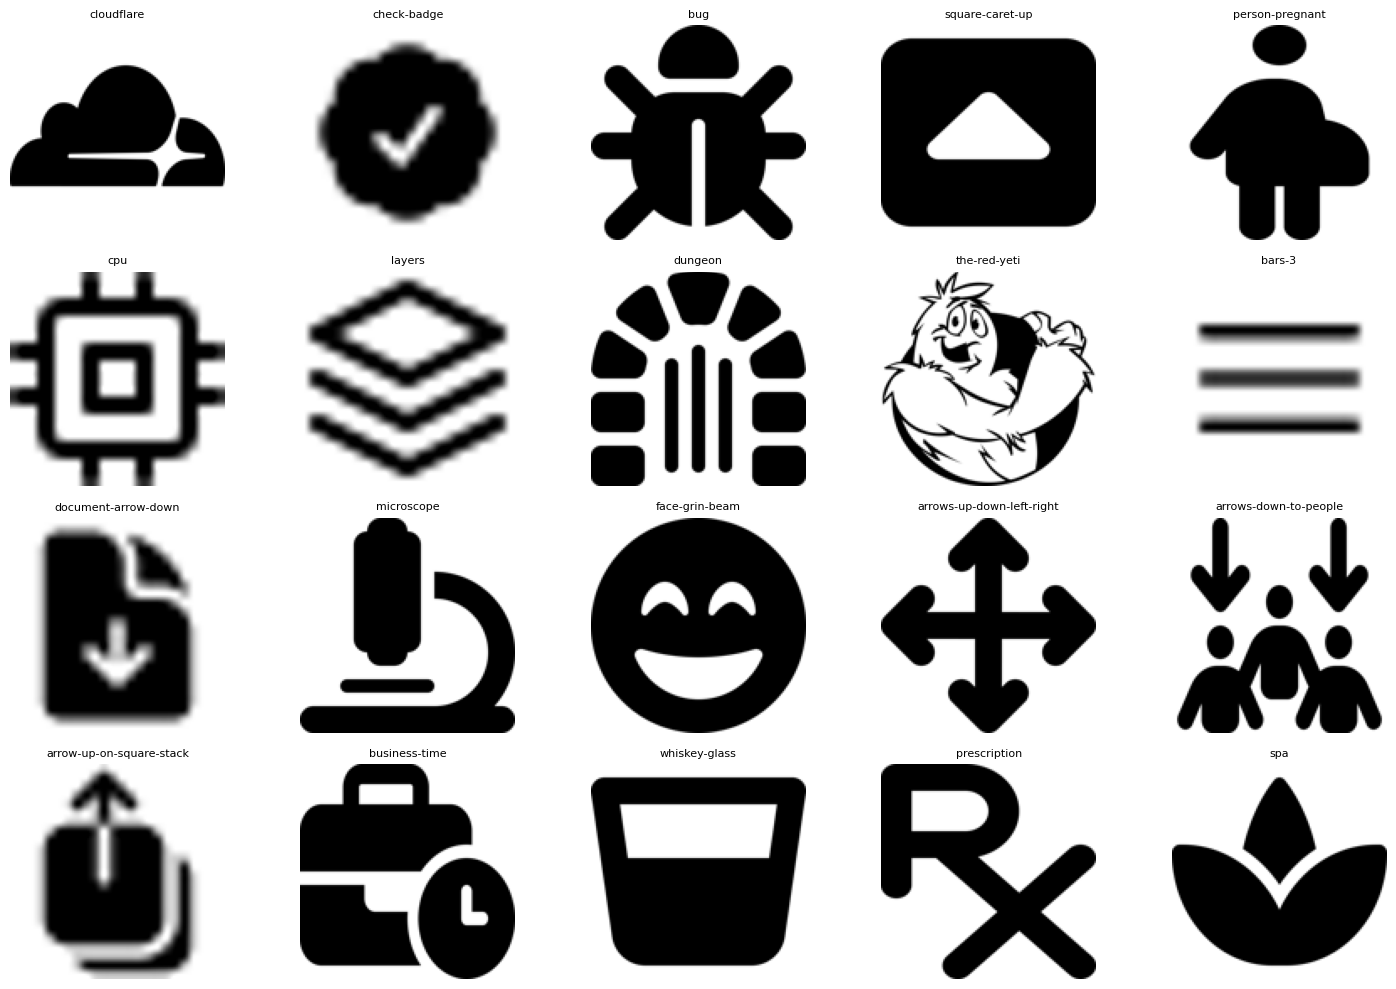

In [4]:

print("Random Samples of Icons from the Dataset\n")

plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(original_images)), 20)
for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(original_images[idx])
    plt.title(icon_labels[idx], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Load Pre-trained Model

We load a pre-trained MobileNet model, which is a convolutional neural network trained on the ImageNet dataset. MobileNet is chosen due to its efficiency and compact size, which makes it suitable for feature extraction on limited computational resources.

This model will help us extract high-level visual features for each icon, capturing important patterns like shapes and textures.

In [5]:
# load MobileNet to extract features
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

The preprocessed icon images are passed through the pre-trained MobileNet model to generate embeddings. These embeddings are multi-dimensional feature maps that represent the visual content of each image. We then flatten the extracted features into a 2D array, where each row represents the visual features of an icon. This is necessary for calculating similarity between icons, as it converts the high-dimensional feature maps into a standard vector format.

In [6]:
# embeddings for each icon
features = base_model.predict(preprocessed_images)
# flatten for similarity calculations
flat_features = features.reshape(features.shape[0], -1)

71/71 [==============================] - 7s 87ms/step


#### Similarity Search Using Visual Features Only

Now we can test visual similarity search to recommend similar icons based purely on their visual features.

We manually or randomly select three icons from the dataset to serve as the basis for similarity searches
  
For each selected icon, we calculate the similarity to all other icons using the cosine similarity of their flattened visual feature vectors. The cosine similarity is used because it is effective for comparing high-dimensional vectors.

The similarity scores are sorted in descending order, and the top five similar icons are displayed. The selected icon is highlighted with a red border for clarity.

This visual-only similarity search highlights how well the visual embeddings capture the icon shapes and visual patterns but may lack semantic alignment, which we will address by incorporating textual features in subsequent steps.

Results using visual features only:


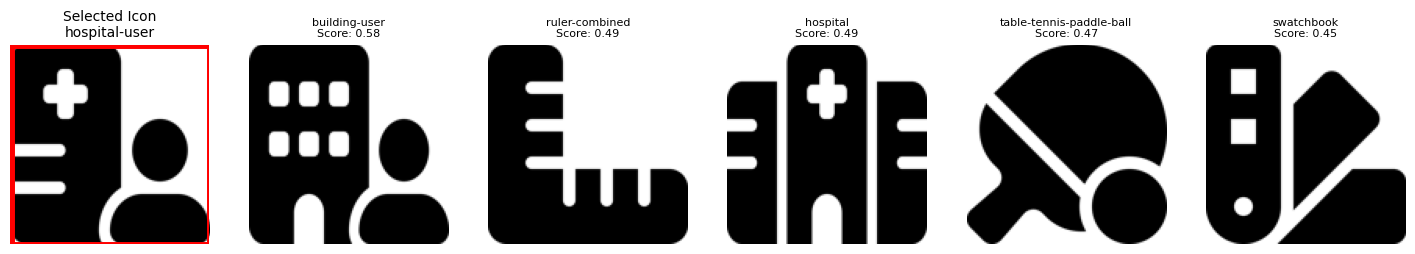

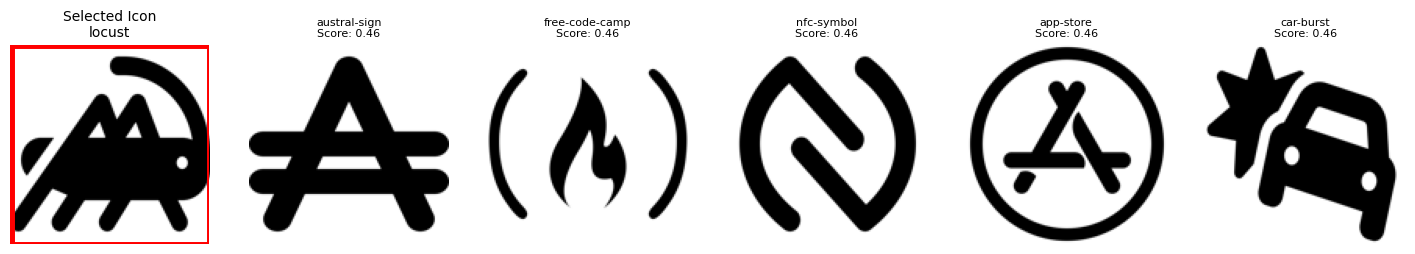

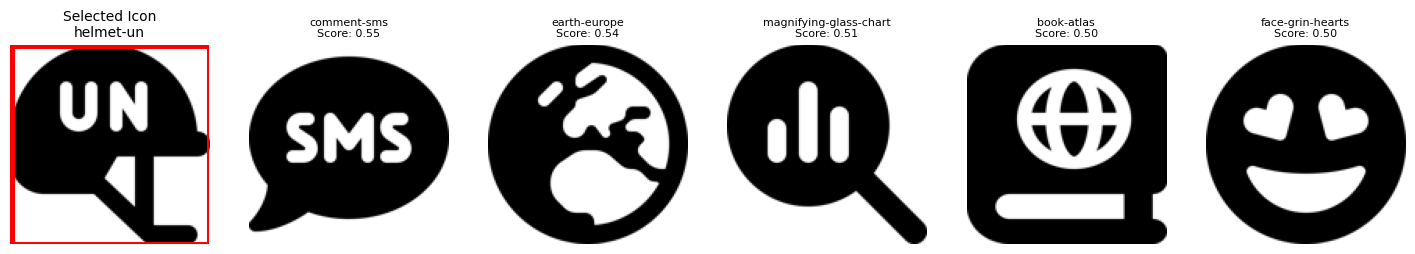

In [7]:
example_icon_names = ["hospital-user", "locust", "helmet-un"]  # Leave this empty for random selection

# icon names to their indices
icon_name_to_index = {label: idx for idx, label in enumerate(icon_labels)}

# indices for the selected examples or choose randomly if not defined
random_indices = []

for name in example_icon_names:
    if name in icon_name_to_index:
        random_indices.append(icon_name_to_index[name])
    else:
        print(f"Warning: Icon '{name}' not found in the dataset. Selecting randomly instead.")
        random_indices.append(random.randint(0, len(flat_features) - 1))
while len(random_indices) < 3:
    random_indices.append(random.randint(0, len(flat_features) - 1))

# print output title
print("Results using visual features only:")

# selected indices for the demo
for example_num, random_index in enumerate(random_indices):
    selected_icon = flat_features[random_index]
    selected_icon_label = icon_labels[random_index]

    # visual similarity
    visual_similarity_scores = []
    for i, visual_feature in enumerate(flat_features):
        if np.linalg.norm(flat_features[random_index]) == 0 or np.linalg.norm(visual_feature) == 0:
            visual_score = 0
        else:
            visual_score = 1 - cosine(flat_features[random_index], visual_feature)
        visual_similarity_scores.append((visual_score, icon_labels[i]))

    # similarity scores in descending order
    similar_icons = sorted(visual_similarity_scores, key=lambda x: x[0], reverse=True)[1:6]

    # results
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 6, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(original_images[random_index])
    plt.title(f"Selected Icon\n{selected_icon_label}", fontsize=10)
    plt.axis('off')
    rect = patches.Rectangle((0, 0), 128, 128, linewidth=5, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # similar icons
    for i, (score, label) in enumerate(similar_icons):
        plt.subplot(1, 6, i + 2)
        img_index = icon_labels.index(label)
        plt.imshow(original_images[img_index])
        plt.title(f"{label}\nScore: {score:.2f}", fontsize=8)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
    plt.show()



#### Findings

The visual-only similarity search shows that the recommendations are based purely on the shape and style of the icons. While the model successfully identifies icons with similar visual patterns, it lacks the ability to consider semantic meaning or context. As a result, icons that may look similar visually but have different meanings can be recommended, which highlights the need to utilize the file names to incorporate semantic information and improve recommendation relevance.

### Text Feature Extraction

To enhance the recommendation system, we incorporate textual features by extracting semantic information from the icon file names. We use a pre-trained GloVe word embedding model which has been trained on Wikipedia data. This model will help us convert words (from icon file names) into numerical vectors, allowing us to incorporate semantic information into the similarity calculation.

In [8]:
# load pre-trained word embedding model GloVe with 50 dimensions
word2vec_model = api.load("glove-wiki-gigaword-50")

For each icon, we tokenize the file name and use the GloVe model to extract word embeddings. The embeddings of all tokens are averaged to generate a textual representation for each icon. This process helps capture the semantic meaning conveyed by the icon names.

After that, we can concatenate the visual and textual Features. This results in a richer representation of each icon, which considers both visual appearance and semantic context.

In [9]:
textual_features = []

for label in icon_labels:
    tokens = re.findall(r'\w+', label)
    word_vectors = []
    for token in tokens:
        if token in word2vec_model:
            word_vectors.append(word2vec_model[token])
    # if there are word vectors, take their average; otherwise, use a zero vector
    if word_vectors:
        avg_vector = np.mean(word_vectors, axis=0)
    else:
        avg_vector = np.zeros(word2vec_model.vector_size)
    textual_features.append(avg_vector)

# list to array for easier processing
textual_features = np.array(textual_features)


# combine visual and textual Features
combined_features = np.concatenate((flat_features, textual_features), axis=1)

### Similarity search using combined features

Now we perform similarity searches using the combined visual and textual features. Again, we use the same randomly selected icons as before to directly compare the results against the visual-only similarity search. The aim is to see whether incorporating textual features improves the relevance of the recommendations.


Displaying results using combined visual and textual features:



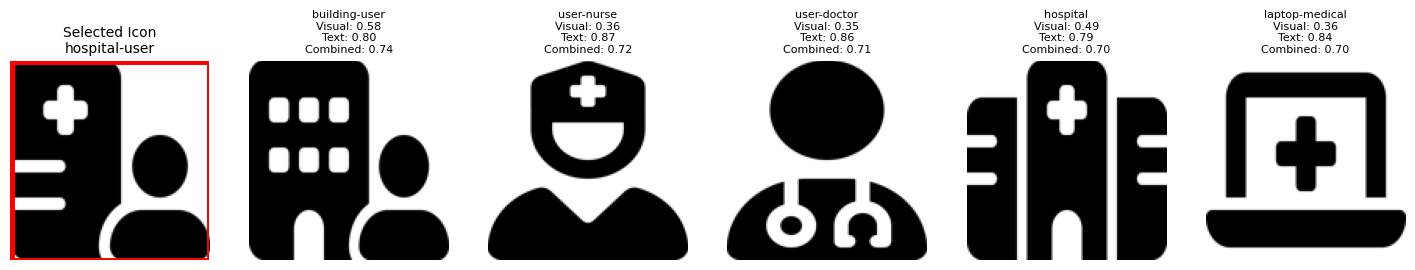

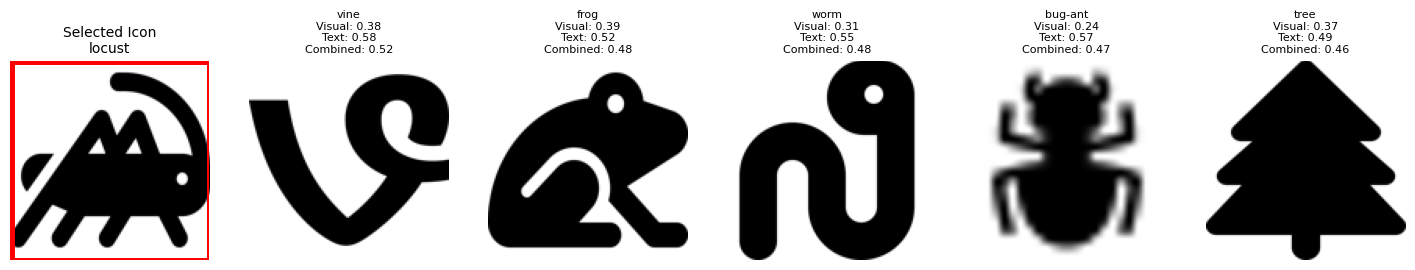

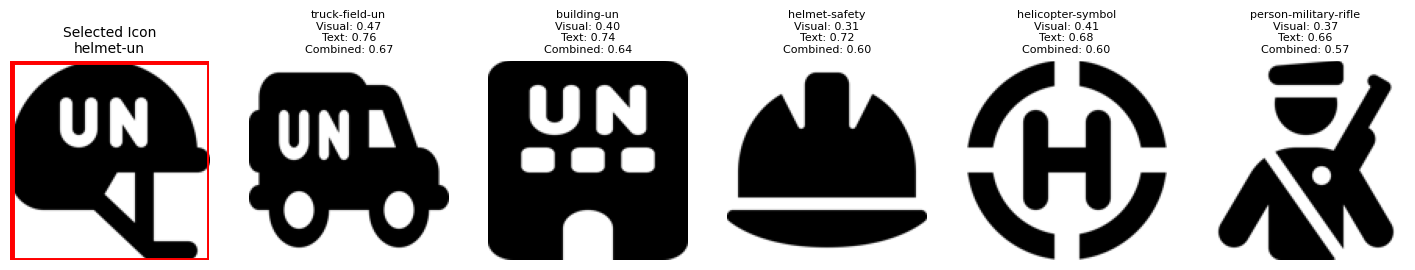

In [10]:
print("\nDisplaying results using combined visual and textual features:\n")
for example_num, random_index in enumerate(random_indices):
    selected_icon = combined_features[random_index]
    selected_icon_label = icon_labels[random_index]

    visual_similarity_scores = []
    textual_similarity_scores = []
    combined_similarity_scores = []

    # Adjust weights for combining visual and textual similarities
    visual_weight = 0.3
    textual_weight = 1 - visual_weight

    for i, (visual_feature, text_feature) in enumerate(zip(flat_features, textual_features)):
        # visual similarity
        if np.linalg.norm(flat_features[random_index]) == 0 or np.linalg.norm(visual_feature) == 0:
            visual_score = 0
        else:
            visual_score = 1 - cosine(flat_features[random_index], visual_feature)
        # textual similarity
        if np.linalg.norm(textual_features[random_index]) == 0 or np.linalg.norm(text_feature) == 0:
            textual_score = 0
        else:
            textual_score = 1 - cosine(textual_features[random_index], text_feature)
        # set to 0 if NaN
        if np.isnan(visual_score):
            visual_score = 0
        if np.isnan(textual_score):
            textual_score = 0
        
        combined_score = (visual_weight * visual_score) + (textual_weight * textual_score)
        
        visual_similarity_scores.append((visual_score, icon_labels[i]))
        textual_similarity_scores.append((textual_score, icon_labels[i]))
        combined_similarity_scores.append((combined_score, icon_labels[i]))

    # sort the combined similarity scores
    similar_icons = sorted(combined_similarity_scores, key=lambda x: x[0], reverse=True)[1:6]

    # results
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 6, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(original_images[random_index])
    plt.title(f"Selected Icon\n{selected_icon_label}", fontsize=10)
    plt.axis('off')
    rect = patches.Rectangle((0, 0), 128, 128, linewidth=5, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # similar icons
    for i, (score, label) in enumerate(similar_icons):
        plt.subplot(1, 6, i + 2)
        img_index = icon_labels.index(label)
        visual_score = next(v[0] for v in visual_similarity_scores if v[1] == label)
        textual_score = next(t[0] for t in textual_similarity_scores if t[1] == label)
        plt.imshow(original_images[img_index])
        plt.title(f"{label}\nVisual: {visual_score:.2f}\nText: {textual_score:.2f}\nCombined: {score:.2f}", fontsize=8)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

    plt.show()

### Discussion & Conclusion

The combined similarity approach, which integrates both visual and textual features, significantly improves the quality of icon recommendations compared to using visual features alone:

- Visual Similarity Alone: The initial results using only visual features were effective in identifying icons with similar shapes and visual patterns. However, they lacked the semantic understanding needed to ensure that the recommendations made sense in the context of their intended meaning. For example, icons with similar geometrical patterns but different meanings were often grouped together.

- Combined Visual and Textual Features: By incorporating the textual features extracted from the icon names, the recommendations became much more context-aware. The textual embeddings provided a way to capture the meaning of each icon, allowing the system to prioritize icons that not only look similar but also serve a similar purpose. This combined approach resulted in more relevant and semantically meaningful recommendations.

In conclusion, incorporating both visual and textual features leads to more accurate and useful recommendations for designers. The visual embeddings help capture the appearance, while the textual embeddings provide crucial context that ensures the recommended icons are not only visually similar but also aligned in terms of their intended meaning. This balanced approach is essential for building an effective and contextually aware icon recommendation system.

### Tools and Methods Used

This project leveraged a variety of deep learning tools and methods to achieve the desired outcome. For visual feature extraction, we used the pre-trained MobileNet model, which provided a compact and effective solution for capturing visual patterns in the icons. MobileNet's pre-trained weights on ImageNet allowed us to quickly extract high-level features without needing extensive computational resources. For textual feature extraction, we utilized GloVe word embeddings, which helped in transforming the icon file names into vector representations that captured semantic meaning. The combination of these features was performed using NumPy to create a final representation for each icon. For similarity calculations, we employed cosine similarity to compare feature vectors, while*matplotlib was used for visualization to help demonstrate the quality of the recommendations. These methods and tools collectively enabled us to create a recommendation system that is both efficient and effective in providing relevant icon suggestions.

### Future Improvements

Future enhancements could include fine-tuning the model, incorporating user feedback, adding metadata, clustering icons, and creating a web-based interface to make the recommendation system more effective, user-friendly, and practical.
